In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
train_data_path='/content/sample_data/mnist_train_small.csv'
if not os.path.exists(train_data_path):
  print("Could not locate data at %s."%train_data_path)


In [2]:
import torch
available_device = (torch.device('cuda') if torch.cuda.is_available() 
         else torch.device('cpu'))
print("Training on device ", available_device)

Training on device  cuda


In [3]:
from torchvision import models, transforms
import torch.nn as nn

In [4]:
class MNISTdigits(torch.utils.data.Dataset):
  def __init__(self, file_name):
        'Initialization'
        column_names=['label']+['pixel%i'%i for i in range(784)]
        self.all_data=pd.read_csv(file_name,names=column_names)
        self.labels = torch.from_numpy(self.all_data["label"].to_numpy())
        data_points=self.all_data.iloc[:,1:].to_numpy()
        self.data_tensor=torch.from_numpy(data_points/255).float()
        self.transform=None
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
       
        X = self.data_tensor[index,:]
        if self.transform:
            X = self.transform(X)
        y = self.labels[index]

        return X, y

In [5]:
class MNISTdigits2d(MNISTdigits):
     def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
       
        X = self.data_tensor[index,:].view(1,28,28)
        if self.transform:
            X = self.transform(X)
        y = self.labels[index]

        return X, y

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import time

class ModelTrainer:
    def __init__(self,model,loss_function,optimizer):
        self.model=model
        self.loss_fn=loss_function
        self.optimizer=optimizer
        self.epochs=[]
        self.losses=[]
    def load_data(self,file_name,split_ratio_list):
        self.data_set=MNISTdigits(file_name)
        self.split_data(split_ratio_list)
    def split_data(self,split_ratio_list):
        split_ratio=torch.tensor(split_ratio_list)
        lengths=split_ratio*(len(self.data_set)//100)
        self.train_set,self.valid_set=torch.utils.data.random_split(self.data_set,lengths)
    def normalize_train_data(self):
        data_loader=torch.utils.data.DataLoader(self.train_set, batch_size=256, shuffle=False)
        means=[]
        stds=[]
        for imgs,labels in data_loader:
            means.append(torch.mean(imgs))
            stds.append(torch.std(imgs))
        self.mean = torch.mean(torch.tensor(means))
        self.std = torch.mean(torch.tensor(stds))
        self.data_set.transform = transforms.Normalize((self.mean),(self.std))
    def train(self,n_epochs, batch_size=64):
        self.model.train()
        self.batch_size=batch_size
        train_loader=torch.utils.data.DataLoader(self.train_set, batch_size=batch_size, shuffle=True)
        initial_n_epochs=len(self.epochs)
        start_time=time.time()
        for epoch in range(initial_n_epochs+1,initial_n_epochs+n_epochs+1): #We add len(epochs) because we would like to continue where we started after running train() the next time
            for imgs,labels in train_loader:
                imgs=imgs.to(device=available_device)
                labels=labels.to(device=available_device)
                self.loss=self.loss_fn(self.model(imgs),labels)
                self.optimizer.zero_grad()
                self.loss.backward()
                self.optimizer.step()
            self.epochs.append(epoch) 
            self.losses.append(self.loss.detach().item())
        end_time=time.time()
        self.training_time=end_time-start_time
    def get_training_time(self):
        return self.training_time
    def get_accuracy(self,dataset):
        self.model.eval()
        data_loader=torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
        correct_guesses=0
        all_samples=0
        with torch.no_grad():
            for imgs, labels in data_loader:
                imgs=imgs.to(device=available_device)
                labels=labels.to(device=available_device)
                _, predicted = torch.max(self.model(imgs), dim=1)
                correct_guesses+=(predicted==labels).sum()
                all_samples+=labels.shape[0]
        return correct_guesses/all_samples
    def get_train_valid_accuracy(self):
        return self.get_accuracy(self.train_set), self.get_accuracy(self.valid_set)
    def plot_loss_agains_n_epochs(self):
        plt.rcParams['figure.figsize'] = [20, 10]
        plt.plot(self.epochs,self.losses)
    def save_parameters(self,file_name):
        torch.save(self.model.state_dict(), file_name)

In [7]:
def analyze_model(model_trainer,batch_size,n_epochs):
    model_trainer.train(n_epochs,batch_size)
    model_trainer.plot_loss_agains_n_epochs()
    train_accuracy, valid_accuracy = model_trainer.get_train_valid_accuracy()
    return model_trainer.training_time,train_accuracy.item(),valid_accuracy.item()

In [8]:
class ResNetModelTrainer(ModelTrainer):
    def __init__(self,learning_rate):
        self.learning_rate=learning_rate
        self.model=models.resnet18().to(device=available_device)
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device=available_device)
        self.model.fc=nn.Linear(512,10).to(device=available_device)
        self.optimizer=torch.optim.SGD(self.model.parameters(),lr=learning_rate)
        self.loss_fn=nn.CrossEntropyLoss()
        self.epochs=[]
        self.losses=[]
    def load_data(self,file_name,split_ratio_list):
        self.data_set=MNISTdigits2d(file_name)
        self.split_data(split_ratio_list)
        self.normalize_train_data()
    def save_parameters(self):
        self.parameters_file_name="./resnet_epochs_%d_batch_size_%d_lr_%f_val_accuracy_%f.pt"%(len(self.epochs),self.batch_size,self.learning_rate,self.get_accuracy(self.valid_set))
        super().save_parameters(self.parameters_file_name)

In [9]:
learning_rate=1.0e-01

resnet=ResNetModelTrainer(learning_rate)
split_ratio=[80,20]
resnet.load_data(train_data_path,split_ratio)

training time: 117.094954 	 train accuracy: 0.999250 	 valid accuracy: 0.988500 


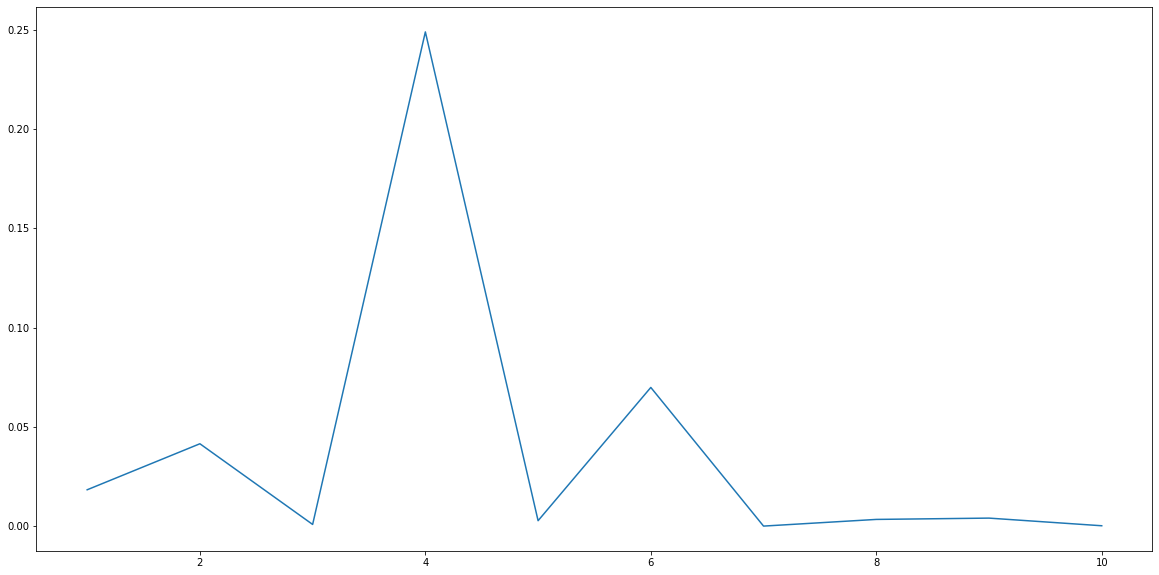

In [10]:
results=analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 113.121030 	 train accuracy: 0.999500 	 valid accuracy: 0.989750 


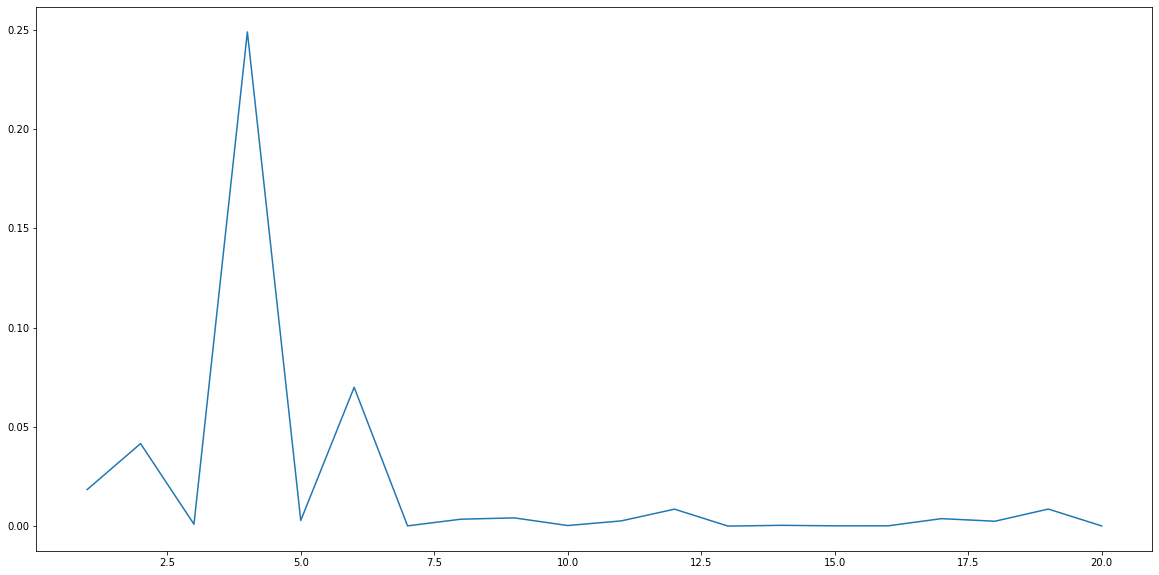

In [11]:
learning_rate=1.0e-03

resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 111.985957 	 train accuracy: 0.999625 	 valid accuracy: 0.989750 


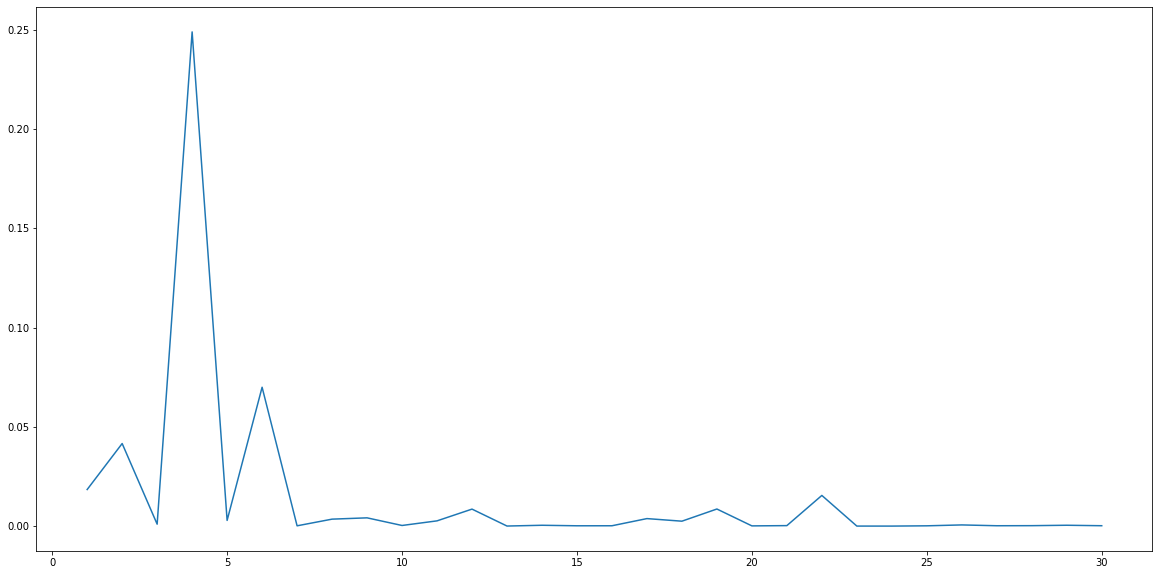

In [12]:
learning_rate=1.0e-06

resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 111.061366 	 train accuracy: 0.999500 	 valid accuracy: 0.989500 


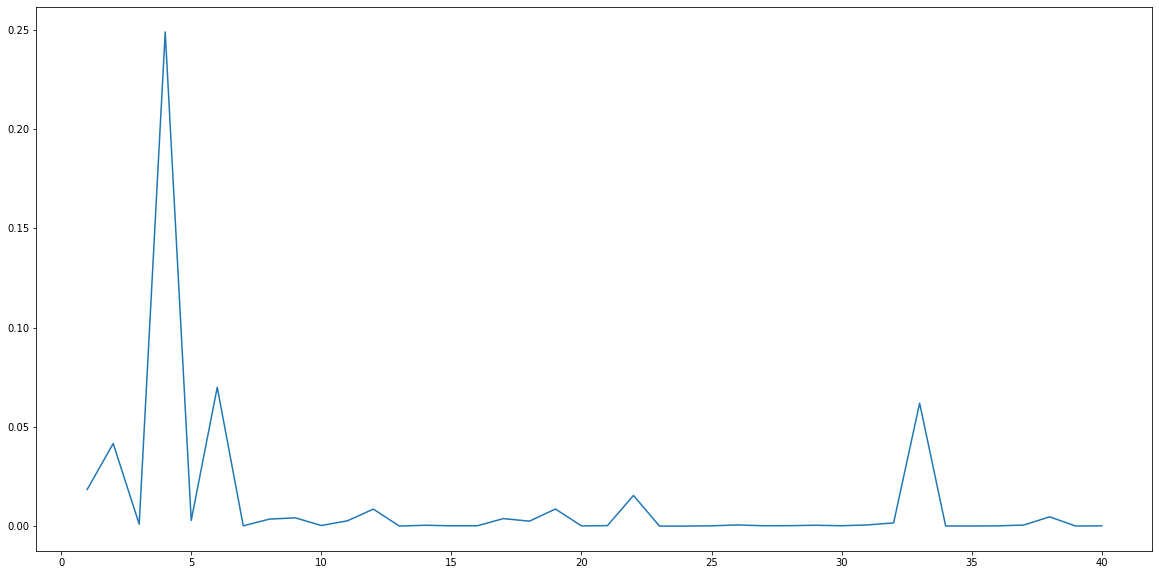

In [13]:
learning_rate=1.0e-06

resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 37.766357 	 train accuracy: 0.999500 	 valid accuracy: 0.990000 


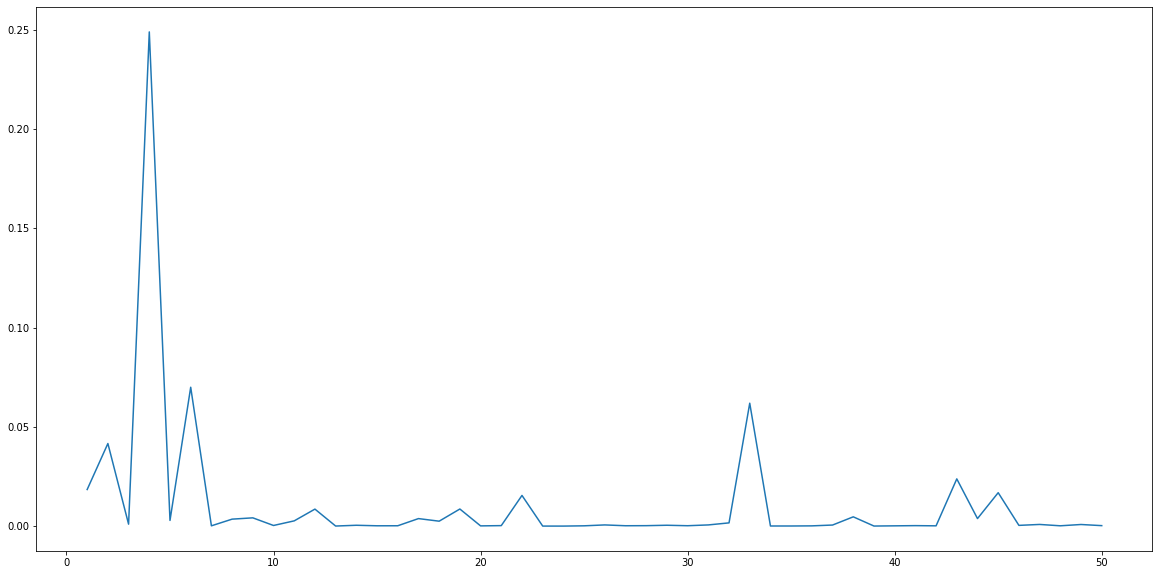

In [14]:
learning_rate=1.0e-06

resnet.optimizer=torch.optim.SGD(resnet.model.parameters(),lr=learning_rate)
results=analyze_model(resnet,64,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

training time: 158.751295 	 train accuracy: 0.996563 	 valid accuracy: 0.983000 


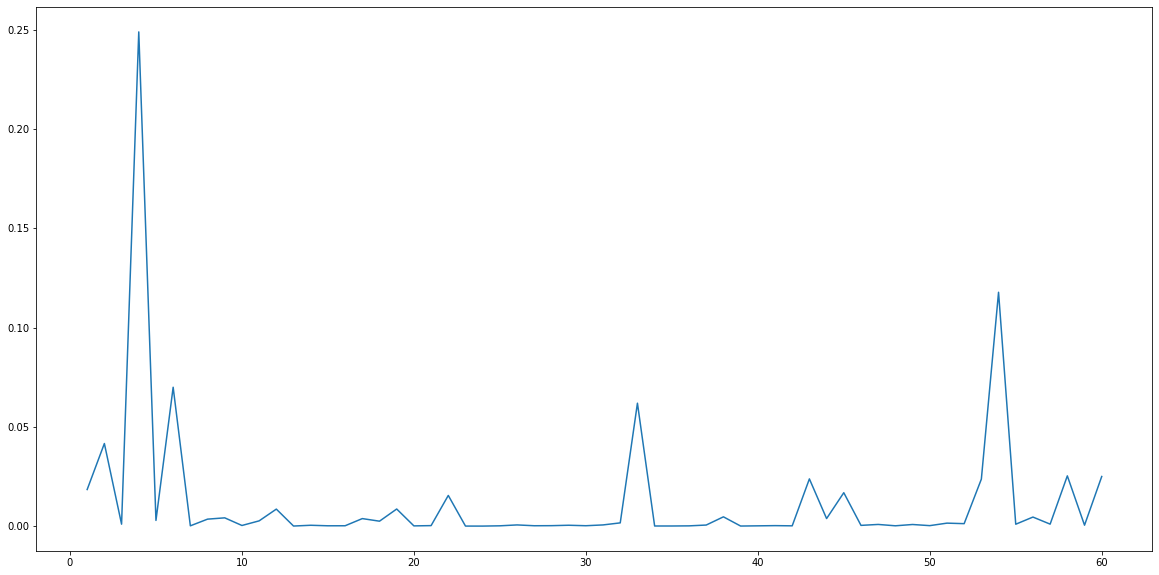

In [15]:
resnet.optimizer=torch.optim.Adam(resnet.model.parameters())
results=analyze_model(resnet,16,10)
print("training time: %f \t train accuracy: %f \t valid accuracy: %f "%results)

In [ ]:
class MNISTdigits2dTest(torch.utils.data.Dataset):
  def __init__(self, file_name):
        'Initialization'
        test_data=pd.read_csv(file_name)
        data_points=test_data.to_numpy()
        self.data_tensor=torch.from_numpy(data_points/255).float()
        self.data_tensor=self.data_tensor.view(-1,1,28,28)
  def __len__(self):
        'Denotes the total number of samples'
        return self.data_tensor.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
       
        X = self.data_tensor[index,:]
        if self.transform:
            X = self.transform(X)

        return index+1, X

In [ ]:
def create_submission_file(model,out_file_name):
    model.eval()
    data_set=MNISTdigits2dTest('../input/digit-recognizer/test.csv')
    data_loader=torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=False)
    indices=[]
    predictions=[]
    with torch.no_grad():
        for batch_indices,batch_imgs in data_loader:
            batch_imgs=batch_imgs.to(device=available_device)
            batch_indices=batch_indices.to(device=available_device)
            _, batch_predictions = torch.max(model(batch_imgs), dim=1)
            indices.append(batch_indices)
            predictions.append(batch_predictions)
    tensor_indices=torch.cat(tuple(indices),dim=0)
    tensor_predictions=torch.cat(tuple(predictions),dim=0)
    result_data_frame=pd.DataFrame({'ImageId':tensor_indices.cpu().numpy(), 'Label':tensor_predictions.cpu().numpy()})
    result_data_frame.set_index('ImageId')
    result_data_frame.to_csv(out_file_name,index=False)

In [ ]:
create_submission_file(resnet.model,'./submission.csv')